In [1]:


import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl
import rebound
#import CreateMovie as movie
from matplotlib.patches import Circle
import matplotlib.lines as mlines
from matplotlib.ticker import FormatStrFormatter
from scipy.interpolate import interp1d
from RV_stab import *
import scipy.optimize as op
import emcee
import corner

%matplotlib inline
plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['legend.borderpad'] = 0.5
plt.rcParams['legend.labelspacing'] = 0.1
plt.rcParams['legend.handletextpad'] = 0.1
plt.rcParams['font.family'] = 'stixgeneral'
plt.rcParams['font.size'] = 18
mpl.rcParams['legend.numpoints'] = 1
plt.rc('lines', linewidth=1.0)
colors = ['4D4D4D','5DA5DA', 'FAA43A', '60BD68', 'F17CB0','B2912F','B276B2','DECF3F','F15854']
                                #  (blue)
                                # (orange)
                                # (green)
                                # (pink)
                                #  (brown)
                                # (purple)
                                #  (yellow)
                                # (red)
                                # ']
mpl.rcParams['axes.color_cycle'] = colors



/home/brett/.local/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


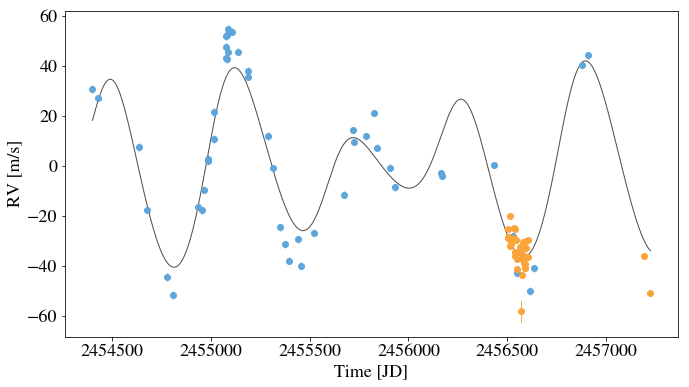

In [2]:
HD200964 = RVSystem(mstar=1.44)
#that's wrong so fuck me are you fucking kidding
epoch=2454399.2
HD200964.clear_planets()
HD200964.add_planet(per=577,mass=1.33,M=325.8,e=0.113623,pomega=319)
HD200964.add_planet(per=912.6,mass=.97,M=191.1,e=0.095,pomega=196.26)

HD200964.RV_data = ['HD200964_KECK.vels','HD200964_APF.vels']

def opt_offsets(offsets):
    HD200964.offsets = offsets
    return -HD200964.log_like(epoch=epoch)



offsets = [-7.35067906,33.92612753]

HD200964.offsets=offsets
HD200964.plot_RV(epoch=epoch,pnts_per_period=1000)



In [24]:
HD200964.calc_chi2(epoch=epoch)/(86-12)

50.33332896887616

  0 %
Integration took 0.00442 seconds
Energy Error is 203.073% 


0

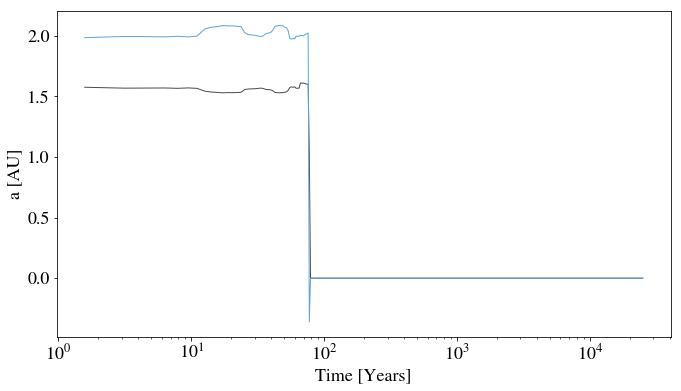

In [25]:
HD200964.orbit_stab(periods=1e4,pnts_per_period=20,outputs_per_period=1,verbose=1,integrator='whfast',safe=1
                  ,timing=1,plot=1,energy_err=1)

## run stability optimization over mass, period, and e initially..##

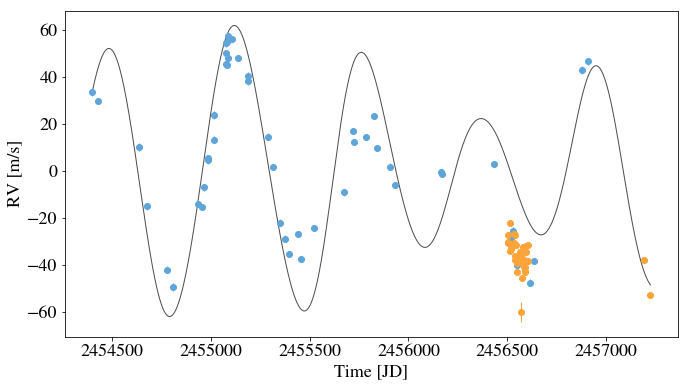

In [45]:
HD200964.clear_planets()
HD200964.add_planet(per=613,mass=1.85,M=338,e=0.04,pomega=319)
HD200964.add_planet(per=825,mass=.9,M=199,e=0.181,pomega=196.26)

HD200964.plot_RV(epoch=epoch,pnts_per_period=1000)

In [40]:
def opt_mp(params):
    pom0,pom1=params
    HD200964.clear_planets()
    HD200964.add_planet(per=613,mass=1.85,M=325.8,e=0.04,pomega=pom0)
    HD200964.add_planet(per=825,mass=.9,M=191.1,e=0.181,pomega=pom1)
    return -HD200964.stab_logprob(epoch=epoch,pnts_per_period=20)

In [41]:
params=[300,190]
opt_mp(params)

inf

In [42]:
t_0 = time.time()
result = op.minimize(opt_mp,params)
print "That took  %.3f seconds" %(time.time()-t_0)

That took  1.068 seconds


In [39]:
print result.x

[ nan -inf]


## the old figures can't explain the new data..so we are on the right track ##
## now to find stability..##

In [10]:
def stability(params):
    e0,e1,M0,M1=params
    HD200964.clear_planets()
    HD200964.add_planet(per=577,mass=1.33,M=M0,e=np.exp(e0),pomega=319)
    HD200964.add_planet(per=912.6,mass=.97,M=M1,e=np.exp(e1),pomega=196.26)
    return -HD200964.stab_logprob(epoch=epoch,pnts_per_period=20)

In [11]:
bounds=[]
params=[np.log(0.1),np.log(0.09),325.8,191.1]
stability(params)

inf

In [12]:
t_0 = time.time()
result = op.minimize(stability,params)
print "That took  %.3f seconds" %(time.time()-t_0)

That took  0.033 seconds


In [13]:
result.x

array([  -2.30258509,   -2.40794561,  325.8       ,  191.1       ])

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
Integration took 253.70408 seconds
Energy Error is 0.000% 


1

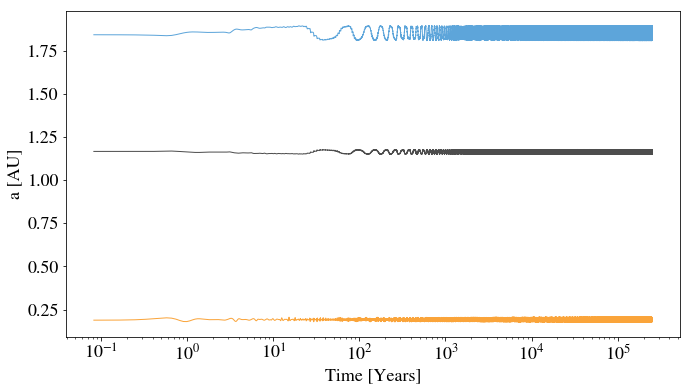

In [27]:
HD200964.clear_planets()
HD200964.add_planet(per=460,mass=1.33,M=325.8,e=0.08,pomega=319)
HD200964.add_planet(per=912.6,mass=.97,M=191.1,e=0.095,pomega=196.26)
HD200964.add_planet(per=30,mass=.1,M=100,e=.3,pomega=200)
HD200964.orbit_stab(periods=1e5,pnts_per_period=20,outputs_per_period=1,verbose=1,integrator='whfast',safe=1
                  ,timing=1,plot=1,energy_err=1)

In [28]:
HD200964.calc_chi2(epoch=epoch)/(86-12)

1067.1174023413187

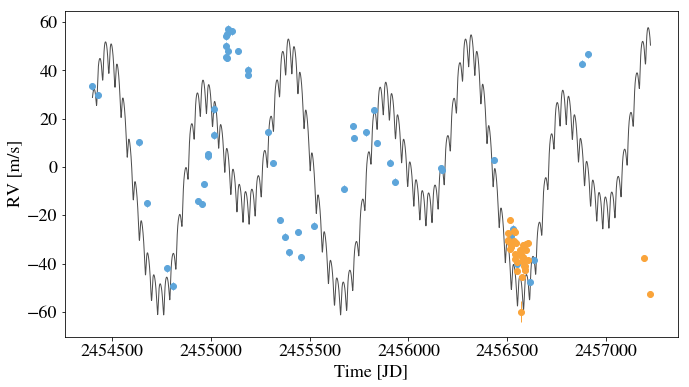

In [29]:
HD200964.plot_RV(epoch=epoch,pnts_per_period=1000)

## going to try a three-planet solution to keep the outer planet stable..##


In [31]:
def opt_angles(params):
    M0,M1,M2,pom0,pom1,pom2,per0,per1,per2=params
    HD200964.clear_planets()
    HD200964.add_planet(per=per0,mass=1.33,M=M0,e=0.08,pomega=pom0)
    HD200964.add_planet(per=per1,mass=.97,M=M1,e=0.095,pomega=pom1)
    HD200964.add_planet(per=per2,mass=.1,M=M2,e=.3,pomega=pom2)
    return -HD200964.stab_logprob(epoch=epoch,pnts_per_period=20)

In [32]:
params=[325,191,100,319,196,200,460,912,30]
opt_angles(params)

39476.780725924968

In [33]:
t_0 = time.time()
result = op.minimize(opt_angles,params)
print "That took  %.3f seconds" %(time.time()-t_0)

That took  35682.841 seconds


In [34]:
result.x

array([ 307.34304272,  211.31049243,  116.58818305,  296.26426836,
        221.77107741,  181.07855534,  465.03353117,  891.62994008,
         29.88886823])

In [35]:
HD200964.clear_planets()
HD200964.add_planet(per=465,mass=1.33,M=307.343,e=0.08,pomega=296.264)
HD200964.add_planet(per=891.6,mass=.97,M=211.31,e=0.095,pomega=221.77)
HD200964.add_planet(per=29.89,mass=.1,M=116.588,e=0.3,pomega=181)

HD200964.calc_chi2(epoch=epoch)/(86-12)

531.75157277945254

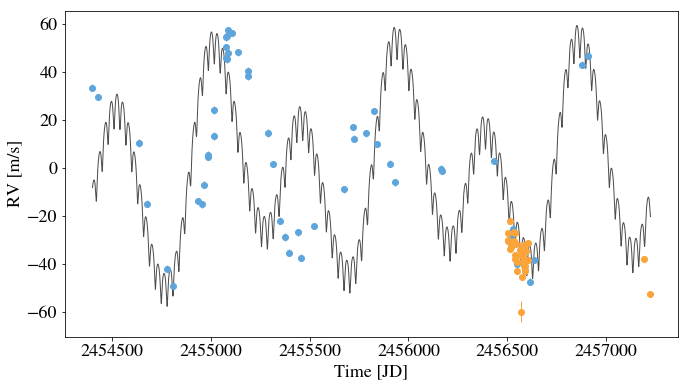

In [36]:
HD200964.plot_RV(epoch=epoch,pnts_per_period=1000)

In [3]:
def opt_mass_e(params):
    mass0,mass1,mass2,e0,e1,e2=params
    HD200964.clear_planets()
    HD200964.add_planet(per=465,mass=mass0,M=307.343,e=np.exp(e0),pomega=296.264)

    HD200964.add_planet(per=891.6,mass=mass1,M=211.31,e=np.exp(e1),pomega=221.77)
    HD200964.add_planet(per=29.89,mass=mass2,M=116.588,e=np.exp(e2),pomega=181)
    return -HD200964.stab_logprob(epoch=epoch,pnts_per_period=20)

In [4]:
bounds=[(0.9,1.6),(0.8,1.2),(0.04,0.2),(np.log(0.02),np.log(0.2)),(np.log(0.02),np.log(0.24)),(np.log(0.05),np.log(0.4))]
params=[1.3,0.97,0.1,np.log(0.08),np.log(0.095),np.log(0.3)]
opt_mass_e(params)
#minimizer= dict(method="L-BFGS-B", bounds=bounds)

In [7]:
t_0 = time.time()
result = op.minimize(opt_mass_e,params,method='L-BFGS-B',bounds=bounds)
print "That took  %.3f seconds" %(time.time()-t_0)

That took  485.348 seconds


In [9]:
result.x

array([ 0.9       ,  1.2       ,  0.04      , -3.91202301, -3.91202301,
       -2.99573227])

In [11]:
HD200964.clear_planets()
HD200964.add_planet(per=465,mass=0.9,M=307.343,e=np.exp(-3.912),pomega=296.264)

HD200964.add_planet(per=891.6,mass=1.2,M=211.31,e=np.exp(-3.912),pomega=221.77)
HD200964.add_planet(per=29.89,mass=0.04,M=116.588,e=np.exp(-2.996),pomega=181)
HD200964.calc_chi2(epoch=epoch)/(86-12)

401.98861445550671

In [4]:
def eval_period(chromosome):
    per0,per1,per2=chromosome
    HD200964.clear_planets()
    HD200964.add_planet(per=per0,mass=0.9,M=307.343,e=np.exp(-3.912),pomega=296.264)

    HD200964.add_planet(per=per1,mass=1.2,M=211.31,e=np.exp(-3.912),pomega=221.77)
    HD200964.add_planet(per=per2,mass=0.04,M=116.588,e=np.exp(-2.996),pomega=181)
    x=-HD200964.stab_logprob(epoch=epoch,pnts_per_period=20)
    return x

bounds=[[400,650],[850,950],[20,40]]
xo=[465,912,28]
length=3
#eval_period(xo)
result=HD200964.genetic_search(bounds,length,eval_period,num_gen=6000,pop_size=8,freq_stat=100)

Gen. 0 (0.00%): Max/Min/Avg Fitness(Raw) [29278.78(39933.53)/18228.33(4755.09)/24398.98(24398.98)]
Gen. 100 (1.67%): Max/Min/Avg Fitness(Raw) [18981.20(41073.30)/14147.05(2480.55)/15817.67(15817.67)]
Gen. 200 (3.33%): Max/Min/Avg Fitness(Raw) [inf(inf)/2476.90(2476.90)/inf(inf)]
Gen. 300 (5.00%): Max/Min/Avg Fitness(Raw) [inf(inf)/2475.98(2475.98)/inf(inf)]
Gen. 400 (6.67%): Max/Min/Avg Fitness(Raw) [3425.45(4332.88)/2708.32(2475.91)/2854.54(2854.54)]
Gen. 500 (8.33%): Max/Min/Avg Fitness(Raw) [inf(inf)/2475.91(2475.91)/inf(inf)]
Gen. 600 (10.00%): Max/Min/Avg Fitness(Raw) [3095.12(2983.58)/2447.39(2475.91)/2579.26(2579.26)]

	A break was detected, you have interrupted the evolution !

Gen. 670 (11.17%): Max/Min/Avg Fitness(Raw) [3499.90(5313.92)/2809.36(2475.91)/2916.58(2916.58)]
Total time elapsed: 106610.104 seconds.


In [6]:
print 2809/(86-12)
result

37


- GenomeBase
	Score:			 2475.907252
	Fitness:		 2809.357386

	Params:		 {'allele': - GAlleles
	Homogeneous:	 False
	List size:	 3
	Alleles:

Allele for 0 position:
- GAlleleRange
	Real:		 True
	Ranges Count:	 1
	Range List:
			 Range from [400] to [650]

Allele for 1 position:
- GAlleleRange
	Real:		 True
	Ranges Count:	 1
	Range List:
			 Range from [850] to [950]

Allele for 2 position:
- GAlleleRange
	Real:		 True
	Ranges Count:	 1
	Range List:
			 Range from [20] to [40]

}

	Slot [Evaluator] (Count: 1)
		Name: eval_period - Weight: 0.50
	Slot [Initializator] (Count: 1)
		Name: G1DListInitializatorAllele - Weight: 0.50
		Doc:  Allele initialization function of G1DList

   To use this initializator, you must specify the *allele* genome parameter with the
   :class:`GAllele.GAlleles` instance.

   
	Slot [Mutator] (Count: 1)
		Name: G1DListMutatorAllele - Weight: 0.50
		Doc:  The mutator of G1DList, Allele Mutator

   To use this mutator, you must specify the *allele* genome paramete

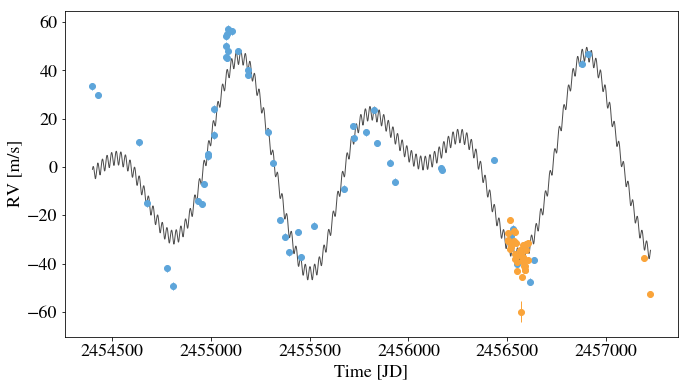

In [7]:
HD200964.clear_planets()
HD200964.add_planet(per=582.9,mass=0.9,M=307.343,e=np.exp(-3.912),pomega=296.264)

HD200964.add_planet(per=892.4,mass=1.2,M=211.31,e=np.exp(-3.912),pomega=221.77)
HD200964.add_planet(per=23.6,mass=0.04,M=116.588,e=np.exp(-2.996),pomega=181)
HD200964.plot_RV(epoch=epoch,pnts_per_period=1000)

In [8]:
HD200964.calc_chi2(epoch=epoch)/(86-12)

67.358296884907588

 0 %
 9 %
19 %
29 %
39 %
49 %
59 %
69 %
79 %
89 %
99 %
Integration took 277.31814 seconds
Energy Error is 0.001% 


1

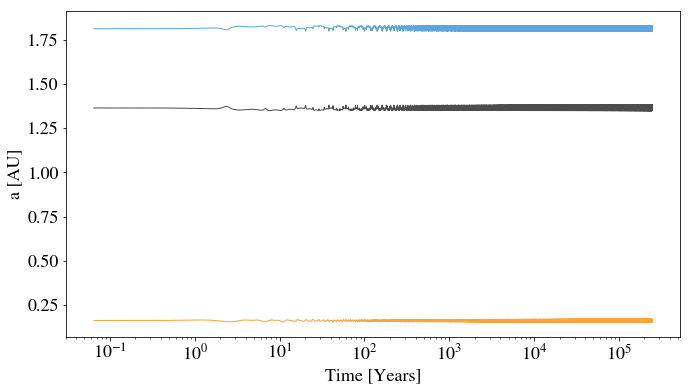

In [9]:
HD200964.orbit_stab(periods=1e5,pnts_per_period=20,outputs_per_period=1,verbose=1,integrator='whfast',safe=1
                  ,timing=1,plot=1,energy_err=1)

In [7]:
def eval_m_e(chromosome):
    mass0,mass1,mass2,e0,e1,e2=chromosome
    HD200964.clear_planets()
    HD200964.add_planet(per=582.9,mass=mass0,M=307.343,e=np.exp(e0),pomega=296.264)

    HD200964.add_planet(per=892.4,mass=mass1,M=211.31,e=np.exp(e1),pomega=221.77)
    HD200964.add_planet(per=23.6,mass=mass2,M=116.588,e=np.exp(e2),pomega=181)
    x=-HD200964.stab_logprob(epoch=epoch,pnts_per_period=14)
    return x

In [8]:
bounds=[[0.8,1.3],[0.8,1.6],[0.04,0.2],[np.log(.02),np.log(0.3)],[np.log(0.02),np.log(0.3)],[np.log(0.05),np.log(0.4)]]
length=6
result=HD200964.genetic_search(bounds,length,eval_m_e,num_gen=300,pop_size=16,freq_stat=10,cores=0)

Gen. 0 (0.00%):

/usr/local/lib/python2.7/dist-packages/pyevolve/GPopulation.py:255: RuntimeWarning: invalid value encountered in double_scalars
  s = self[ind].score - self.stats["rawAve"]


 Max/Min/Avg Fitness(Raw) [inf(inf)/4127.30(4127.30)/inf(inf)]
Gen. 10 (3.33%): Max/Min/Avg Fitness(Raw) [inf(inf)/2409.56(2409.56)/inf(inf)]
Gen. 20 (6.67%): Max/Min/Avg Fitness(Raw) [inf(inf)/2361.78(2361.78)/inf(inf)]
Gen. 30 (10.00%): Max/Min/Avg Fitness(Raw) [3898.70(4708.20)/2822.33(2290.89)/3248.92(3248.92)]
Gen. 40 (13.33%): Max/Min/Avg Fitness(Raw) [inf(inf)/2239.31(2239.31)/inf(inf)]
Gen. 50 (16.67%): Max/Min/Avg Fitness(Raw) [inf(inf)/2225.95(2225.95)/inf(inf)]
Gen. 60 (20.00%): Max/Min/Avg Fitness(Raw) [inf(inf)/2225.66(2225.66)/inf(inf)]
Gen. 70 (23.33%): Max/Min/Avg Fitness(Raw) [inf(inf)/2197.24(2197.24)/inf(inf)]
Gen. 80 (26.67%): Max/Min/Avg Fitness(Raw) [inf(inf)/2192.10(2192.10)/inf(inf)]
Gen. 90 (30.00%): Max/Min/Avg Fitness(Raw) [inf(inf)/2192.10(2192.10)/inf(inf)]
Gen. 100 (33.33%): Max/Min/Avg Fitness(Raw) [inf(inf)/2192.10(2192.10)/inf(inf)]
Gen. 110 (36.67%): Max/Min/Avg Fitness(Raw) [inf(inf)/2191.26(2191.26)/inf(inf)]
Gen. 120 (40.00%): Max/Min/Avg Fitness(Ra

In [9]:
result

- GenomeBase
	Score:			 2182.251011
	Fitness:		 2182.251011

	Params:		 {'allele': - GAlleles
	Homogeneous:	 False
	List size:	 6
	Alleles:

Allele for 0 position:
- GAlleleRange
	Real:		 True
	Ranges Count:	 1
	Range List:
			 Range from [0.8] to [1.3]

Allele for 1 position:
- GAlleleRange
	Real:		 True
	Ranges Count:	 1
	Range List:
			 Range from [0.8] to [1.6]

Allele for 2 position:
- GAlleleRange
	Real:		 True
	Ranges Count:	 1
	Range List:
			 Range from [0.04] to [0.2]

Allele for 3 position:
- GAlleleRange
	Real:		 True
	Ranges Count:	 1
	Range List:
			 Range from [-3.91202300543] to [-1.20397280433]

Allele for 4 position:
- GAlleleRange
	Real:		 True
	Ranges Count:	 1
	Range List:
			 Range from [-3.91202300543] to [-1.20397280433]

Allele for 5 position:
- GAlleleRange
	Real:		 True
	Ranges Count:	 1
	Range List:
			 Range from [-2.99573227355] to [-0.916290731874]

}

	Slot [Evaluator] (Count: 1)
		Name: eval_m_e - Weight: 0.50
	Slot [Initializator] (Count: 1)
		Name: G1

In [10]:
HD200964.clear_planets()
HD200964.add_planet(per=582.9,mass=1.00,M=307.343,e=np.exp(-3.9),pomega=296.264)

HD200964.add_planet(per=892.4,mass=1.1764,M=211.31,e=np.exp(-3.87),pomega=221.77)
HD200964.add_planet(per=23.6,mass=0.076,M=116.588,e=np.exp(-2.8),pomega=181)


In [13]:
HD200964.calc_chi2(epoch=epoch)/(86-17)

60.499498419781446

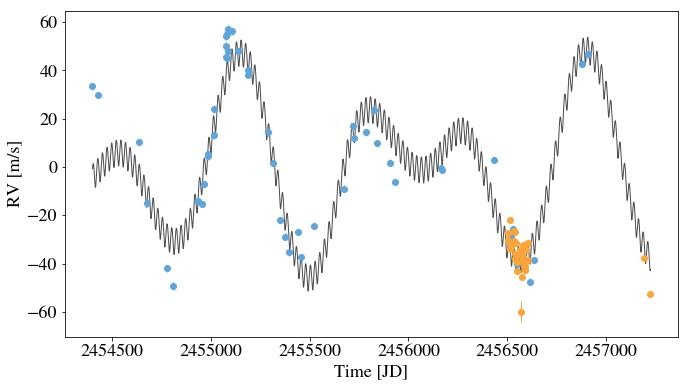

In [12]:
HD200964.plot_RV(epoch=epoch,pnts_per_period=1000)

In [30]:
def two_planet_eval(chromosome):
    M0,M1,pom0,pom1= chromosome
    HD200964.clear_planets()
    HD200964.add_planet(per=613.8,mass=1.85,M=M0,e=0.04,pomega=pom0)
    HD200964.add_planet(per=825,mass=0.9,M=M1,e=0.181,pomega=pom1)

    
    x=-HD200964.stab_logprob(epoch=epoch,pnts_per_period=30)
    return x

In [31]:
bounds=[[1,360],[1,360],[1,360],[1,360]]
length=4
result=HD200964.genetic_search(bounds,length,two_planet_eval,num_gen=2000,mutation=0.3,pop_size=200,freq_stat=10,cores=0)

Gen. 0 (0.00%): Max/Min/Avg Fitness(Raw) [inf(inf)/13034.00(13034.00)/inf(inf)]
Gen. 10 (0.50%): Max/Min/Avg Fitness(Raw) [inf(inf)/6104.10(6104.10)/inf(inf)]
Gen. 20 (1.00%): Max/Min/Avg Fitness(Raw) [inf(inf)/3729.55(3729.55)/inf(inf)]
Gen. 30 (1.50%): Max/Min/Avg Fitness(Raw) [inf(inf)/2306.40(2306.40)/inf(inf)]
Gen. 40 (2.00%): Max/Min/Avg Fitness(Raw) [inf(inf)/2279.34(2279.34)/inf(inf)]
Gen. 50 (2.50%): Max/Min/Avg Fitness(Raw) [inf(inf)/2252.77(2252.77)/inf(inf)]
Gen. 60 (3.00%): Max/Min/Avg Fitness(Raw) [inf(inf)/2252.77(2252.77)/inf(inf)]
Gen. 70 (3.50%): Max/Min/Avg Fitness(Raw) [inf(inf)/2223.24(2223.24)/inf(inf)]
Gen. 80 (4.00%): Max/Min/Avg Fitness(Raw) [inf(inf)/2192.41(2192.41)/inf(inf)]
Gen. 90 (4.50%): Max/Min/Avg Fitness(Raw) [inf(inf)/2163.40(2163.40)/inf(inf)]
Gen. 100 (5.00%): Max/Min/Avg Fitness(Raw) [inf(inf)/2146.78(2146.78)/inf(inf)]
Gen. 110 (5.50%): Max/Min/Avg Fitness(Raw) [inf(inf)/2132.96(2132.96)/inf(inf)]
Gen. 120 (6.00%): Max/Min/Avg Fitness(Raw) [inf(i

Gen. 1020 (51.00%): Max/Min/Avg Fitness(Raw) [inf(inf)/1945.11(1945.11)/inf(inf)]
Gen. 1030 (51.50%): Max/Min/Avg Fitness(Raw) [inf(inf)/1945.11(1945.11)/inf(inf)]
Gen. 1040 (52.00%): Max/Min/Avg Fitness(Raw) [inf(inf)/1945.11(1945.11)/inf(inf)]

	A break was detected, you have interrupted the evolution !

Gen. 1040 (52.00%): Max/Min/Avg Fitness(Raw) [inf(inf)/1945.11(1945.11)/inf(inf)]
Total time elapsed: 16253.063 seconds.


## checking original solution as well as finding initial parameter space that M and pom inhabit 


In [32]:
result

- GenomeBase
	Score:			 1945.108751
	Fitness:		 1945.108751

	Params:		 {'allele': - GAlleles
	Homogeneous:	 False
	List size:	 4
	Alleles:

Allele for 0 position:
- GAlleleRange
	Real:		 True
	Ranges Count:	 1
	Range List:
			 Range from [1] to [360]

Allele for 1 position:
- GAlleleRange
	Real:		 True
	Ranges Count:	 1
	Range List:
			 Range from [1] to [360]

Allele for 2 position:
- GAlleleRange
	Real:		 True
	Ranges Count:	 1
	Range List:
			 Range from [1] to [360]

Allele for 3 position:
- GAlleleRange
	Real:		 True
	Ranges Count:	 1
	Range List:
			 Range from [1] to [360]

}

	Slot [Evaluator] (Count: 1)
		Name: two_planet_eval - Weight: 0.50
	Slot [Initializator] (Count: 1)
		Name: G1DListInitializatorAllele - Weight: 0.50
		Doc:  Allele initialization function of G1DList

   To use this initializator, you must specify the *allele* genome parameter with the
   :class:`GAllele.GAlleles` instance.

   
	Slot [Mutator] (Count: 1)
		Name: G1DListMutatorAllele - Weight: 0.50
		Doc

In [4]:
HD200964.clear_planets()
HD200964.add_planet(per=613.8,mass=1.85,M=98.16,e=0.04,pomega=206.32)
HD200964.add_planet(per=825,mass=0.9,M=58.07,e=0.181,pomega=292.6)

HD200964.calc_chi2(epoch=epoch)/(86-12)

49.967944939065411

In [6]:
HD200964.chi2_prob(chi=49.97,degrees=74)

0.01443413950961487

### ok so that's within like 2 sigma..needs to be about 1/8 of that though, time to shrink chi even more, but first check stability

  0 %
 10 %
 19 %
 29 %
 39 %
 49 %
Integration took 4.56083 seconds
Energy Error is 238.933% 


0

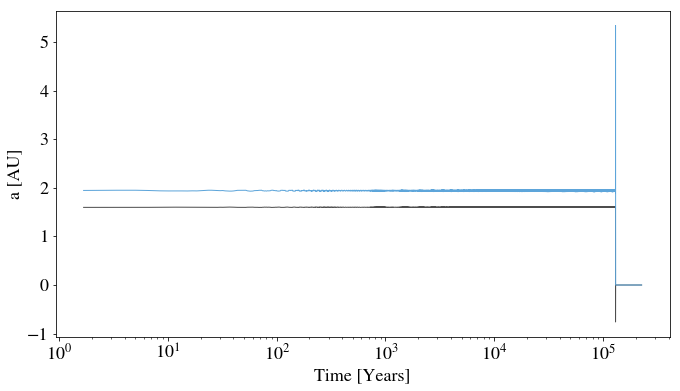

In [10]:
HD200964.orbit_stab(periods=1e5,pnts_per_period=30,outputs_per_period=1,verbose=1,integrator='whfast',safe=1
                  ,timing=1,plot=1,energy_err=1)

In [6]:
def long_planet_eval(chromosome):
    per0,per1,mass0,mass1,M0,M1,e0,e1,pom0,pom1=chromosome
    HD200964.clear_planets()
    HD200964.add_planet(per=per0,mass=mass0,M=M0,e=np.exp(e0),pomega=pom0)
    HD200964.add_planet(per=per1,mass=mass1,M=M1,e=np.exp(e1),pomega=pom1)

    
    x=-HD200964.stab_logprob(epoch=epoch,pnts_per_period=30,time=1e5)
    return x
    

In [9]:
bounds=[[550,650],[800,850],[1.6,2],[0.7,1.2],[80,110],[40,75],[np.log(0.001),np.log(0.2)],[np.log(0.04),np.log(0.4)],[185,215],[275,305]]
length=10

result=HD200964.genetic_search(bounds,length,long_planet_eval,num_gen=2000,mutation=0.25,pop_size=300,freq_stat=10,cores=0)

Gen. 0 (0.00%): Max/Min/Avg Fitness(Raw) [inf(inf)/1852.40(1852.40)/inf(inf)]
Gen. 10 (0.50%): Max/Min/Avg Fitness(Raw) [inf(inf)/1339.44(1339.44)/inf(inf)]
Gen. 20 (1.00%): Max/Min/Avg Fitness(Raw) [inf(inf)/1332.01(1332.01)/inf(inf)]
Gen. 30 (1.50%): Max/Min/Avg Fitness(Raw) [inf(inf)/1290.30(1290.30)/inf(inf)]
Gen. 40 (2.00%): Max/Min/Avg Fitness(Raw) [inf(inf)/1285.48(1285.48)/inf(inf)]
Gen. 50 (2.50%): Max/Min/Avg Fitness(Raw) [inf(inf)/1285.48(1285.48)/inf(inf)]
Gen. 60 (3.00%): Max/Min/Avg Fitness(Raw) [inf(inf)/1285.48(1285.48)/inf(inf)]
Gen. 70 (3.50%): Max/Min/Avg Fitness(Raw) [inf(inf)/1284.92(1284.92)/inf(inf)]
Gen. 80 (4.00%): Max/Min/Avg Fitness(Raw) [inf(inf)/1284.47(1284.47)/inf(inf)]
Gen. 90 (4.50%): Max/Min/Avg Fitness(Raw) [inf(inf)/1280.72(1280.72)/inf(inf)]
Gen. 100 (5.00%): Max/Min/Avg Fitness(Raw) [inf(inf)/1280.72(1280.72)/inf(inf)]
Gen. 110 (5.50%): Max/Min/Avg Fitness(Raw) [inf(inf)/1278.50(1278.50)/inf(inf)]
Gen. 120 (6.00%): Max/Min/Avg Fitness(Raw) [inf(inf

In [10]:
result

- GenomeBase
	Score:			 1275.934999
	Fitness:		 1275.934999

	Params:		 {'allele': - GAlleles
	Homogeneous:	 False
	List size:	 10
	Alleles:

Allele for 0 position:
- GAlleleRange
	Real:		 True
	Ranges Count:	 1
	Range List:
			 Range from [550] to [650]

Allele for 1 position:
- GAlleleRange
	Real:		 True
	Ranges Count:	 1
	Range List:
			 Range from [800] to [850]

Allele for 2 position:
- GAlleleRange
	Real:		 True
	Ranges Count:	 1
	Range List:
			 Range from [1.6] to [2]

Allele for 3 position:
- GAlleleRange
	Real:		 True
	Ranges Count:	 1
	Range List:
			 Range from [0.7] to [1.2]

Allele for 4 position:
- GAlleleRange
	Real:		 True
	Ranges Count:	 1
	Range List:
			 Range from [80] to [110]

Allele for 5 position:
- GAlleleRange
	Real:		 True
	Ranges Count:	 1
	Range List:
			 Range from [40] to [75]

Allele for 6 position:
- GAlleleRange
	Real:		 True
	Ranges Count:	 1
	Range List:
			 Range from [-6.90775527898] to [-1.60943791243]

Allele for 7 position:
- GAlleleRange
	Real

In [10]:
HD200964.clear_planets()
HD200964.add_planet(per=609.3,mass=1.59,M=93.8,e=np.exp(-2.7),pomega=206.95)
HD200964.add_planet(per=810.4,mass=1.00,M=50.77,e=np.exp(-2.35),pomega=304.9)

HD200964.calc_chi2(epoch=epoch,star='A type')/(86-12)

30.56947478123782

In [11]:
HD200964.chi2_prob(30.253723,74)

1.4402548529468144e-06

In [13]:
HD200964.orbit_stab(periods=1e8,pnts_per_period=80,outputs_per_period=1,verbose=1,integrator='whfast',safe=1
                  ,timing=1,plot=1,energy_err=1)

  0 %
 10 %
 19 %
 29 %
 39 %
 49 %
 59 %
 69 %
 79 %
 89 %
 99 %
Integration took 13501.56064 seconds
Energy Error is 0.000% 


1

MemoryError: 

In [14]:
HD200964.clear_planets()
HD200964.add_planet(per=601.3,mass=1.65,M=93.9,e=np.exp(-2.36329),pomega=201.5)
HD200964.add_planet(per=811.8,mass=0.96,M=51.95,e=np.exp(-2.8544639),pomega=293.06)

HD200964.calc_chi2(epoch=epoch,star='A type')/(86-12)

34.871576015854274

## here is the second long stability value, you can use both jackson. ##